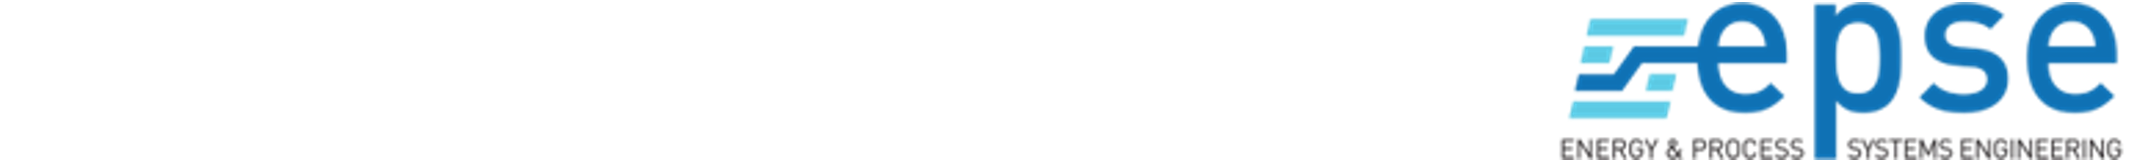

# <center>  Heat Pump Design </center> 

In [ ]:
from pylab import *
import Fluid_CP as FCP #calculation of  thermodynamic states
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import Compressormodel_SP as CM
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

First, we define given parameters.

In [24]:

#refrigerant
delta_T_sh=10. #K #superheating --> assumption
delta_T_sc=5 #K #subcooling --> assumption
fluid="Isobutane"# ---> must be varied 
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out= T_so_in #°C -> parallel flow, same temperature in and out 

#sink
fluid_si="water"


#heat exchanger
min_pinch=0.5 #K -> assumption



h_refVapLiq = 2000 #W/m^2/K
h_refVap = 200 #W/m^2/K
h_refLiq = 1000 #W/m^2/K

stainless_lambda_steel = 15 #W/m/K

d_i = 0.00635 #m
d_out = 0.0055 #m
h_water = 1000 #W/m^2/K
d_w = 0.00635 - 0.0055 #m


### Isentropic efficiency and refrigerant massflow are calculated through the given Compressor function

In [25]:
def calc_eta(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    eta_is = etas_fun[0]  # extract isentropic efficiency
    return eta_is

def calc_mdot(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    m_dot = etas_fun[1]  # extract mass flow rate
    return m_dot

### Create Heat pump process


In [26]:
def HP(param):
    
    T_co, T_ev = param

    # Thermodynamic states of the heat pump process
    # State 1*: evaporator: T1 = T_ev and x1 = 1.0 (saturated vapor)
    param_calc = T_ev, T_co, delta_T_sh, None, _D
    
    eta_is = calc_eta(param_calc)
    m_dot = calc_mdot(param_calc)


    # State 1*: saturated vapor at evaporator pressure
    state1_sat = FCP.state(["T", "x"], [T_ev, 1.0], fluid, Eh)

    # State 1: outlet evaporator, superheated vapor if delta_T_sh > 0
    if delta_T_sh > 0.0:
        state1 = FCP.state(["T", "p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat

    # State 3*: saturated liquid at condenser outlet temperature
    state3_sat = FCP.state(["T", "x"], [T_co, 0.0], fluid, Eh)

    # State 3: subcooled liquid at condenser outlet
    state3 = FCP.state(["T", "p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)

    # State 3x: dewpoint at condenser pressure (x = 1)
    state3x = FCP.state(["T", "x"], [T_co, 1.0], fluid, Eh)

    # State 2s: ideal isentropic compression (s2s = s1, p2s = p3)
    state2s = FCP.state(["p", "s"], [state3["p"], state1["s"]], fluid, Eh)

    # h2 from compressor efficiency
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is

    # State 2: actual compressor outlet
    state2 = FCP.state(["p", "h"], [state3["p"], h2], fluid, Eh)

    # State 4: after expansion valve (isenthalpic), p4 = p1, h4 = h3
    state4 = FCP.state(["p", "h"], [state1["p"], state3["h"]], fluid, Eh)

    

    return {
        "state1_sat": state1_sat,
        "state1": state1,
        "state2s": state2s,
        "state2": state2,
        "state3_sat": state3_sat,
        "state3": state3,
        "state3x": state3x,
        "state4": state4,
        "h2": h2,
        "eta_is": eta_is,
        "m_dot": m_dot
    }

## COP function
We define a function that returns the reciprocal value of the coefficient of performance (*COP*). This function is called *calc_COP* and reads the variable parameter *param=[T_co,T_ev]*, a vector of the evaporation temperature *T_co* and the condensation temperature *T_ev*, as input parameters. The optimizer *minimize* requires that all optimization variables are passed in a vector. 

In [27]:
# Use your code above here (copied or imported)
COP_DATA = []         
COP_POLY_COEFFS = np.array([])  
COP_POLY_DEGREE = 3   

HEAT_POLY_COEFFS = np.array([])  # will store polynomial coefficients
HEAT_POLY_DEGREE = 3             # adjust as needed

def generate_heat_fit(heat_dict):
    global HEAT_POLY_COEFFS

    if not heat_dict:
        raise ValueError("No heat data to fit.")

    # Sort by temperature
    temps, heat_vals = zip(*sorted(heat_dict.items()))
    
    # Fit polynomial
    HEAT_POLY_COEFFS = np.polyfit(temps, heat_vals, HEAT_POLY_DEGREE)


def get_heat_from_fit(T):
    if HEAT_POLY_COEFFS is None or len(HEAT_POLY_COEFFS) == 0:
        raise RuntimeError("Heat polynomial fit has not been generated.")
    
    return float(np.polyval(HEAT_POLY_COEFFS, T))


def print_heat_fit_equation():
    terms = [f"{coef:.6g} * T^{HEAT_POLY_DEGREE - i}" 
            for i, coef in enumerate(HEAT_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("Heat(T) ≈", equation)



def store_COP_data(param, T_si_in):
    cop_val = 1. / calc_COP(param)  # invert reciprocal COP
    COP_DATA.append((T_si_in, cop_val))
    return 1. / cop_val

def generate_COP_fit():
    global COP_POLY_COEFFS
    if not COP_DATA:
        raise ValueError("No COP data to fit.")
    COP_DATA.sort(key=lambda x: x[0])
    T_vals, cop_vals = zip(*COP_DATA)
    COP_POLY_COEFFS = np.polyfit(T_vals, cop_vals, COP_POLY_DEGREE)

def get_COP_from_fit(T_si_in):
    if COP_POLY_COEFFS is None or len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("COP polynomial fit has not been generated.")
    return float(np.polyval(COP_POLY_COEFFS, T_si_in))

def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

def print_COP_fit_equation():
    if len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("Fit not generated yet.")

    terms = [f"{coef:.6g} * T^{COP_POLY_DEGREE - i}" 
        for i, coef in enumerate(COP_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("COP(T_si_in) ≈", equation)


## Pinch Points

### Pinch points evaporator (in- or outlet)

In [28]:
def pinch_evap(param):

    T_co, T_ev = param
    
    hp_vals = HP(param)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    #between the inlet temperature of the source *T_so_in* and the outlet temperature of the refrigerant *T_1*.

    state1 = hp_vals["state1"]

    state4 = hp_vals["state4"]

    delta_T_out_ev=T_so_in-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference 
    #between the outlet temperature of the source *T_so_out* and the inlet temperature of the refrigerant *T_4*. 
    delta_T_in_ev=T_so_out-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

### Pinch points condenser (in- , outlet or dew line refrigerant)

In [29]:
def pinch_con(param):
    
    T_co, Tev = param

    hp_vals = HP(param)

    state3 = hp_vals["state3"]

    state2 = hp_vals["state2"]

    state3x = hp_vals["state3x"]
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in*.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=state3x["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]


## Condenser Length

### R_L_evap and R_L_sh

In [30]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h_transfer,d_tube_inner):
    R_L_conv=1./(h_transfer*pi*d_tube_inner) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #mK/W
    return R_L_cond


In [31]:
#convective heat transfer inner tube wall
R_L_h_refVap = calc_RL_conv(h_refVap,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(stainless_lambda_steel,d_w,d_out,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_out)

R_L_sh=R_L_h_refVap+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during condensation in superheated state=",round(R_L_sh,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_reflat=calc_RL_conv(h_refVapLiq,d_i)

R_L_lat=R_L_h_reflat+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during latent=",round(R_L_lat,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_refLiq=calc_RL_conv(h_refLiq,d_i)

R_L_sc=R_L_h_refLiq+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during subcooling=",round(R_L_sc,4),"mK/W")

thermal resistance per meter during condensation in superheated state= 0.3116 mK/W
thermal resistance per meter during latent= 0.086 mK/W
thermal resistance per meter during subcooling= 0.1111 mK/W


In [32]:
def calc_spec_length(param):

    T_co,T_ev =param

    hp_vals = HP(param)

    state2 = hp_vals["state2"]

    state3 = hp_vals["state3"]

    state3_sat = hp_vals["state3_sat"]

    state3x = hp_vals["state3x"]

    h2 = hp_vals["h2"]

    m_dot = hp_vals["m_dot"]
    
    #heat flow condenser
    Q_con_sh = m_dot*(h2-state3x['h']) #kW
    Q_con_lat =m_dot*(state3x["h"]-state3_sat["h"]) #kW
    Q_con_sc = m_dot*(state3_sat['h'] - state3['h']) #kW

    P = (Q_con_lat + Q_con_sc + Q_con_sh) / (1/calc_COP(param))

    print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
    print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
    print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
    print("Heat out= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
    print("Work in= ",round(P,2),"kW")

    
    T3sat = state3_sat['T']
    T3x = state3x['T']
    T2 = state2['T']
    #temperarture of air=constant 
    eps = 1e-20 #to avoid division by zero in logarithm
    T_water_worst_case = T_si_in - eps #T_si_in #can be adjusted, depends on the heatpump design and controlling 
    
    #logarithmic mean temperature difference during condensing, all steps 
    deltaT_m_sc=((T3sat - T_si_in) - ((T3sat - delta_T_sc)- T_si_in))/(log((T3sat - T_si_in)/((T3sat - delta_T_sc) - T_si_in )))
    deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(log((T2 - T_water_worst_case)/(T3x - T_water_worst_case)))

    L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
    L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
    L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)
    
    print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
    print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
    print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
    L_t=L_con_sc+L_con_lat+L_con_sh
    print("Total length of condenser tube=",round(L_t,2),"m")


    return L_t, Q_con_lat + Q_con_sc + Q_con_sh

In [33]:
def tot_heat(x):
    _, Q_out = calc_spec_length(x)  # or however you compute total Q
    P = Q_out / calc_COP(x)
    return P


# NEW PART WITH COP AND SCHEDULE

## Control Strategy with heat-up included
### Defining variables

In [34]:
# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W£
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta
Q_hp_W = 4000   # W

T_env = 20      # °C
T_pasta_0 = 7        # °C
T_WP_on = 85      # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg

print(V_water)

24.543288000000004


### Define Pasta Cooking Schedule

In [35]:
# --- Pasta batch schedule (7 min cook, 5 min break) ---
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

### Define heat pump control logic


In [63]:
# --- Heat pump control logic ---
def calc_HP(T, T_on, T_off, op_times):
    global WP, time
    if T <= T_on: # Temperature is below T
        if WP == 0:
            time = 0
        WP = 1
    elif T >= T_off:
        if WP == 1:
            op_times.append(time)
        WP = 0

    if WP == 1:
        time += 1
        return get_heat_from_fit(T) * 1000
    else:
        return 0

### Define Temperature ODE's for system

In [37]:
# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_water, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_water * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_water, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_water * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Define the main simulation

In [81]:
# --- Main simulation with morning heat-up ---
def T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_store, duration_s, op_times, m_water, m_pasta):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    binary_pasta = np.zeros(duration_s)
    
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_on:
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_water, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0

        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_water, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index

In [82]:
import ast
import pandas as pd
#read file that gives the cut-off temperatures for the heat pump (csv called "controlling_temperature_off_for_fixed_Q.csv")
global worst_case_dict, T_so_in, min_pinch, max_length_condenser, nominal_Q, R_L_sc, R_L_lat, R_L_sh, R_env
global R_pasta, c_l, c_pasta, Q_hp_W, T_env, T_pasta_0, T_WP_on, T_WP_off, rho_water, V_water, m_water, m_pasta
global COP_res, Q_in, W_in, T_so_in

COP_res = []  # List to store COP results
Q_in = []  # List to store heat input results
W_in = []  # List to store work input results
min_pinch = 0.5  # K, minimum pinch temperature

# --- Global control variables ---
WP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W£
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta


T_env = 20      # °C
T_pasta_0 = 7        # °C
T_WP_on = 87      # °C ---->>>>>> to be changed as well¨!!!!!!!!!
T_WP_off = 91
rho_water = 997.     # kg/m3


# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg
T_so_in = 20  # °C, can be adjusted based on the heat pump design and controlling

diameter = [35,40,45,50]
refrigerants = ["Isobutane","Butane","Isobutene","DimethyEther"]


In [59]:
for i in diameter:
        for j in refrigerants:
        
            global _D, COP_DATA,Q_hp_W, T_si_in , max_length_condenser, T_so_out, T_ev_op, T_co_op,Q_fit_dict, HEAT_DATA
            HEAT_DATA = {}  # Dictionary to store heat output data
            Q_fit_dict = {}  # Dictionary to store COP fit data
            _D = diameter  # mm
            fluid = j
            max_length_condenser = 66.15
            
            #create fit for cop's by iterating through all the temperatures from 20 to 93
            T_si_in_values = np.linspace(20,93,3) #range of sink temperatures in °C
            # store cop data for each temperature -> have to call optimization for each temperature
            COP_DATA.clear()  # clear previous data 
            
            for T_si_in_val in T_si_in_values:
                T_si_in = T_si_in_val  # set the current sink temperature
                T_si_out = T_si_in_val  # assuming parallel flow, same temperature in and out
                print("Calculating COP for T_si_in =", T_si_in_val)
                bounds=[(T_si_in_val,np.inf),(-np.inf,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

                NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
                NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
                NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [max_length_condenser], [max_length_condenser])


                #Syntax:  NCs=(NC1, NC2,....)
                NCs=[NC1,NC2,NC3a]

                #Define an appropriate initial guess (starting point).
                T_co_start = T_si_in_val + 10 #°C
                T_ev_start = T_so_in - 10 #°C
                #Use minimize to optimize the COP

                Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
                #Check if the optimization terminated successfull and print the COP
                print("Success optimization=",Opti.success)
                COP=1./calc_COP(Opti.x)
                print("optimized COP = ",round(COP,2))

                T_ev_op=Opti.x[1]
                T_co_op=Opti.x[0]
                

                store_COP_data((T_co_op, T_ev_op), T_si_in_val)
                _, Q_hp_W = calc_spec_length((T_co_op,T_ev_op))  # calculate total heat output as the second output
                HEAT_DATA[T_si_in_val] = Q_hp_W  # store the heat output for the fit
                

                

            generate_COP_fit() #generates fit for exactly these conditions: power, diameter, refrigerant
            generate_heat_fit(HEAT_DATA)



Calculating COP for T_si_in = 20.0


TypeError: can't multiply sequence by non-int of type 'float'

In [60]:

COP_DATA = []
HEAT_DATA = {}  # Dictionary to store heat output data
Q_fit_dict = {}  # Dictionary to store COP fit data
_D = 35  # mm
fluid = "Isobutane"
max_length_condenser = 66.15

#create fit for cop's by iterating through all the temperatures from 20 to 93
T_si_in_values = np.linspace(20,93,15) #range of sink temperatures in °C
# store cop data for each temperature -> have to call optimization for each temperature
COP_DATA.clear()  # clear previous data 

for T_si_in_val in T_si_in_values:
    T_si_in = T_si_in_val  # set the current sink temperature
    T_si_out = T_si_in_val  # assuming parallel flow, same temperature in and out
    print("Calculating COP for T_si_in =", T_si_in_val)
    bounds=[(T_si_in_val,np.inf),(-np.inf,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

    NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
    NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
    NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [max_length_condenser], [max_length_condenser])


    #Syntax:  NCs=(NC1, NC2,....)
    NCs=[NC1,NC2,NC3a]

    #Define an appropriate initial guess (starting point).
    T_co_start = T_si_in_val + 10 #°C
    T_ev_start = T_so_in - 10 #°C
    #Use minimize to optimize the COP

    Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
    #Check if the optimization terminated successfull and print the COP
    print("Success optimization=",Opti.success)
    COP=1./calc_COP(Opti.x)
    print("optimized COP = ",round(COP,2))

    T_ev_op=Opti.x[1]
    T_co_op=Opti.x[0]


    store_COP_data((T_co_op, T_ev_op), T_si_in_val)
    _, Q_hp_W = calc_spec_length((T_co_op,T_ev_op))  # calculate total heat output as the second output
    HEAT_DATA[T_si_in_val] = Q_hp_W  # store the heat output for the fit




generate_COP_fit() #generates fit for exactly these conditions: power, diameter, refrigerant
generate_heat_fit(HEAT_DATA)

Calculating COP for T_si_in = 20.0
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensing subcooling=  3.6 m
Total length of condenser tube= 69.83 m
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensing subcooling=  3.6 m
Total length of condenser tube= 69.83 m
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensing subcooling=  3.6 m
Total length

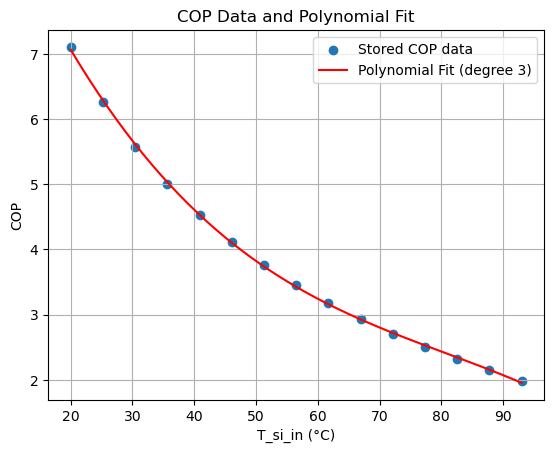

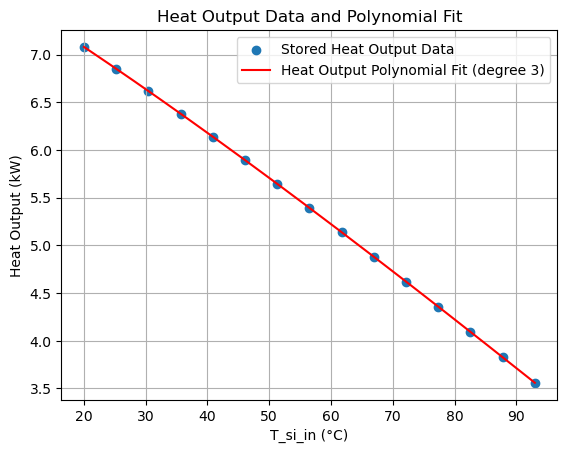

COP(T_si_in) ≈ -1.11133e-05 * T^3 + 0.00269612 * T^2 + -0.253422 * T^1 + 11.1429 * T^0
Heat(T) ≈ 2.87522e-07 * T^3 + -0.000103805 * T^2 + -0.0396478 * T^1 + 7.91205 * T^0


In [61]:
    # Plotting the data points and the fit
plt.scatter(*zip(*COP_DATA), label='Stored COP data')

T_plot = np.linspace(min(T_si_in_values), max(T_si_in_values), 200)
COP_fit_vals = [get_COP_from_fit(T) for T in T_plot]

plt.plot(T_plot, COP_fit_vals, 'r-', label='Polynomial Fit (degree {})'.format(COP_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('COP')
plt.title('COP Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#plotting heat output data
plt.scatter(*zip(*HEAT_DATA.items()), label='Stored Heat Output Data')
T_heat_plot = np.linspace(min(T_si_in_values), max(T_si_in_values), 200)
heat_fit_vals = [get_heat_from_fit(T) for T in T_heat_plot]
plt.plot(T_heat_plot, heat_fit_vals, 'r-', label='Heat Output Polynomial Fit (degree {})'.format(HEAT_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('Heat Output (kW)')
plt.title('Heat Output Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#print the equations for the fits

    
print_COP_fit_equation()
print_heat_fit_equation()

In [ ]:
# --- Step 1: Preliminary simulation to find heating-up time only ---
prelim_duration = 3 * 60 * 60  # simulate up to 3 hours for safety
op_times_prelim = []

# Run preliminary sim just to get heat-up time
_, _, T_water_prelim, _, prelim_start_index = T_water_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_water, prelim_duration, op_times_prelim, m_water, m_pasta)

if prelim_start_index is None:
    raise RuntimeError("Cooking schedule never started. Increase preliminary duration or check parameters.")

heating_up_time = prelim_start_index  # in seconds
print("Calculated heating-up time =", heating_up_time / 60, "minutes")

RuntimeError: Cooking schedule never started. Increase preliminary duration or check parameters.

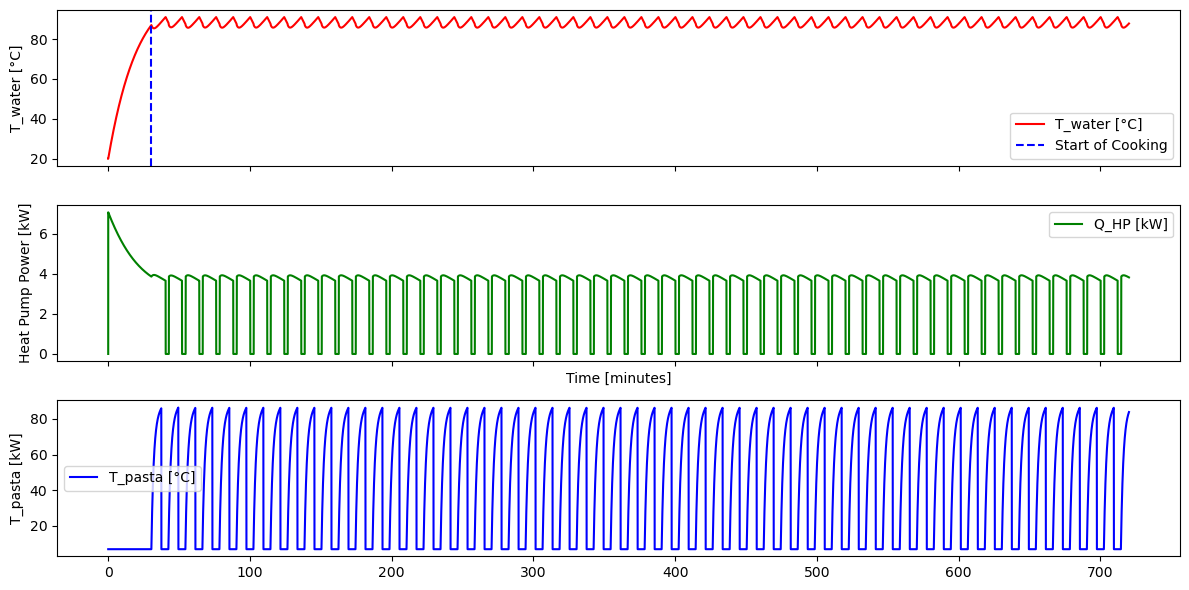

Time until cooking starts (heat-up) = 30.47 minutes
Min operating time = 9.27 minutes
Max operating time = 40.48 minutes
Number of heat pump on-cycles = 57
total_duration = 12.002777777777776 hours
91.00989199812099
20.621010470283817


In [83]:
heating_up_time = 10


duration_seconds = heating_up_time + 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_water_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_water, duration_seconds, op_times, m_water,m_pasta)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [kW]')
ax3.legend()

plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60 

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("total_duration =", total_duration, "hours")
print(max(T_water[heating_up_time:]))
print(min(T_water[heating_up_time:]))

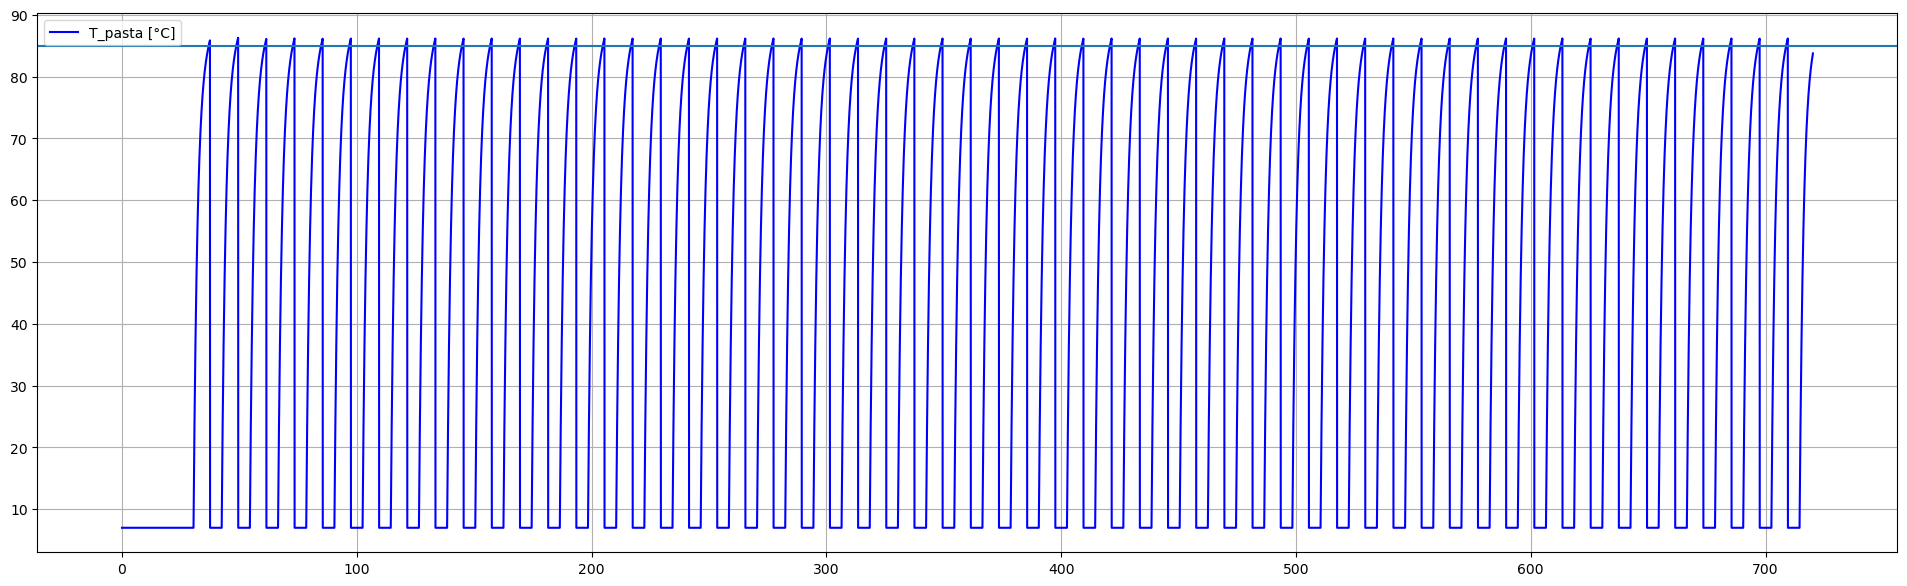

86.29941192833122
91.00989199812099
85.7171608012379


In [84]:
plt.figure(figsize=(24,7))
plt.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
plt.axhline(y=85)
plt.legend()
plt.grid(True)
plt.show()

print(max(list(T_pasta)))

print(max(list(T_water)))
print(min(list(T_water[60*104:])))